## importing libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

## reading data from .csv file

In [2]:
df = pd.read_csv("roberta_sentiment_analysis.csv")
df.head(5)

,Subject,body,date,from,roberta_neg,roberta_neu,roberta_pos,label
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,0.012207,0.492302,0.495490,positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,0.653594,0.316744,0.029662,negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,0.043858,0.908734,0.047408,neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,0.023093,0.845511,0.131396,neutral
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,0.241674,0.686705,0.071622,neutral


## Examine the overall data structure (e.g., number of records, data types, missing values).

In [3]:
df.info()
# datatypes and column names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Subject      2191 non-null   object 
 1   body         2191 non-null   object 
 2   date         2191 non-null   object 
 3   from         2191 non-null   object 
 4   roberta_neg  2191 non-null   float64
 5   roberta_neu  2191 non-null   float64
 6   roberta_pos  2191 non-null   float64
 7   label        2191 non-null   object 
dtypes: float64(3), object(5)
memory usage: 137.1+ KB


In [4]:
# missing values in total
df.isna().sum()

Subject        0
body           0
date           0
from           0
roberta_neg    0
roberta_neu    0
roberta_pos    0
label          0
dtype: int64

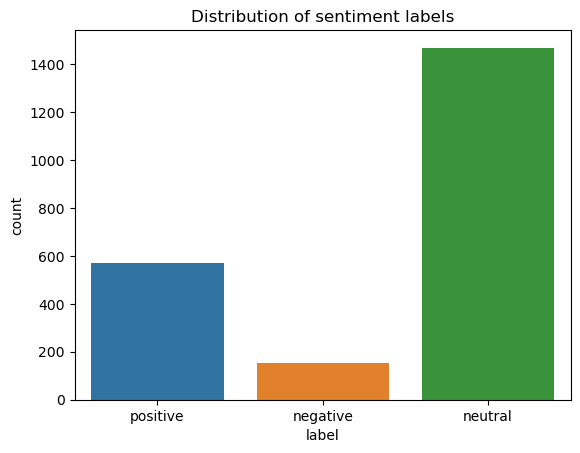

In [5]:
# Create a count plot (bar chart) showing the number of occurrences of each sentiment label.
sns.countplot(x='label', data=df)

# Add a title to the plot for clarity.
plt.title("Distribution of sentiment labels")

# Display the plot.
plt.show()


## Analyze trends over time.

In [6]:
# Convert the 'date' column to datetime format (if it's not already),
# which enables datetime-specific operations like extracting periods, filtering, etc.
df['date'] = pd.to_datetime(df['date'])

# Create a new column 'weekly' that represents the week period for each date,
# using pandas' Period object (e.g., '2022-01-03/2022-01-09').
df['weekly'] = df['date'].dt.to_period('W')

# Generate a summary table (pivot table) that counts the number of entries per label (e.g., 'positive', 'neutral', 'negative')
# for each weekly period. Missing combinations are filled with 0.
summary = df.pivot_table(index='weekly', columns='label', aggfunc='size', fill_value=0)

# Display the resulting pivot table.
print(summary)


label                  negative  neutral  positive
weekly                                            
2009-12-28/2010-01-03         0        9         1
2010-01-04/2010-01-10         2       13         3
2010-01-11/2010-01-17         1       16         6
2010-01-18/2010-01-24         1       14         3
2010-01-25/2010-01-31         1       17         4
...                         ...      ...       ...
2011-11-28/2011-12-04         0       12         4
2011-12-05/2011-12-11         2       12         7
2011-12-12/2011-12-18         1       14         6
2011-12-19/2011-12-25         3       13         5
2011-12-26/2012-01-01         0       14         6

[105 rows x 3 columns]


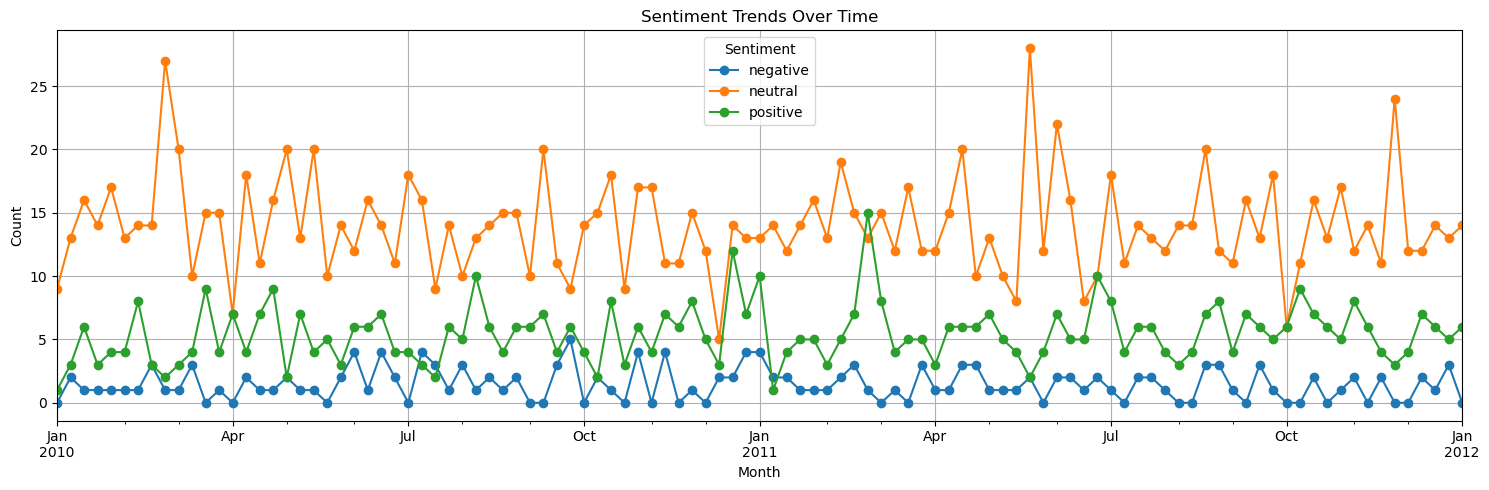

In [7]:
# Plot the pivot table 'summary' as a line chart.
# Each sentiment label will have its own line, marked with circles.
summary.plot(kind='line', marker='o', figsize=(15, 5))

# Set the plot title for context.
plt.title('Sentiment Trends Over Time')

# Label the x-axis to indicate that the data is grouped by month/week.
plt.xlabel('Month')

# Label the y-axis to show that the values represent counts of each sentiment.
plt.ylabel('Count')

# Add grid lines for better readability of the plot.
plt.grid(True)

# Add a legend to differentiate the sentiment lines.
plt.legend(title='Sentiment')

# Adjust layout to prevent label or title cutoff.
plt.tight_layout()

# Display the plot.
plt.show()


### defining a continoius sentiment labeling

In [9]:
df['sentiment_score'] = df['roberta_pos'] - df['roberta_neg']
df['sentiment_score'].head(10)

0    0.483283
1   -0.623932
2    0.003550
3    0.108302
4   -0.170052
5    0.103829
6   -0.024429
7    0.328795
8    0.205145
9   -0.206039
Name: sentiment_score, dtype: float64

## Explore additional patterns for employee engagement

In [11]:
from scipy.stats import kurtosis, skew
import numpy as np

# Define rolling window sizes (in days)
windows = [3, 5, 7, 10, 30]

# Compute rolling statistics for each window
for w in windows:
    # Rolling variance with minimum 3 data points
    df[f'rolling_variance_{w}d'] = df['sentiment_score'].rolling(window=w, min_periods=3).var()
    
    # Rolling mean
    df[f'rolling_mean_{w}d'] = df['sentiment_score'].rolling(window=w, min_periods=3).mean()
    
    # Rolling standard deviation
    df[f'rolling_std_{w}d'] = df['sentiment_score'].rolling(window=w, min_periods=3).std()
    
    # Rolling skewness (asymmetry of distribution)
    df[f'rolling_skew_{w}d'] = df['sentiment_score'].rolling(window=w, min_periods=3).apply(skew, raw=True)
    
    # Rolling kurtosis (peakedness of distribution), fisher=True gives "excess kurtosis"
    df[f'rolling_kurtosis_{w}d'] = df['sentiment_score'].rolling(window=w, min_periods=3).apply(
        lambda x: kurtosis(x, fisher=True), raw=True
    )

# Display first 10 rows for all rolling features
df[[
    'rolling_mean_3d', 'rolling_std_3d', 'rolling_variance_3d', 'rolling_skew_3d', 'rolling_kurtosis_3d',
    'rolling_mean_5d', 'rolling_std_5d', 'rolling_variance_5d', 'rolling_skew_5d', 'rolling_kurtosis_5d',
    'rolling_mean_7d', 'rolling_std_7d', 'rolling_variance_7d', 'rolling_skew_7d', 'rolling_kurtosis_7d',
    'rolling_mean_10d', 'rolling_std_10d', 'rolling_variance_10d', 'rolling_skew_10d', 'rolling_kurtosis_10d',
    'rolling_mean_30d', 'rolling_std_30d', 'rolling_variance_30d', 'rolling_skew_30d', 'rolling_kurtosis_30d'
]].head(10)


,rolling_mean_3d,rolling_std_3d,rolling_variance_3d,rolling_skew_3d,rolling_kurtosis_3d,rolling_mean_5d,rolling_std_5d,rolling_variance_5d,rolling_skew_5d,rolling_kurtosis_5d,...,rolling_mean_10d,rolling_std_10d,rolling_variance_10d,rolling_skew_10d,rolling_kurtosis_10d,rolling_mean_30d,rolling_std_30d,rolling_variance_30d,rolling_skew_30d,rolling_kurtosis_30d
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.045700,0.555248,0.308301,-0.161668,-1.5,-0.045700,0.555248,0.308301,-0.161668,-1.500000,...,-0.045700,0.555248,0.308301,-0.161668,-1.500000,-0.045700,0.555248,0.308301,-0.161668,-1.500000
3,-0.170693,0.395996,0.156812,-0.651849,-1.5,-0.007199,0.459851,0.211463,-0.455357,-0.985068,...,-0.007199,0.459851,0.211463,-0.455357,-0.985068,-0.007199,0.459851,0.211463,-0.455357,-0.985068
4,-0.019400,0.140589,0.019765,-0.291904,-1.5,-0.039770,0.404847,0.163901,-0.232215,-0.765692,...,-0.039770,0.404847,0.163901,-0.232215,-0.765692,-0.039770,0.404847,0.163901,-0.232215,-0.765692
5,0.014026,0.159432,0.025419,-0.706480,-1.5,-0.115661,0.305714,0.093461,-1.056172,-0.431767,...,-0.015837,0.366821,0.134558,-0.446333,-0.351480,-0.015837,0.366821,0.134558,-0.446333,-0.351480
6,-0.030218,0.137032,0.018778,-0.077465,-1.5,0.004240,0.113959,0.012987,-0.605033,-0.889348,...,-0.017064,0.334876,0.112142,-0.470152,0.081820,-0.017064,0.334876,0.112142,-0.470152,0.081820
7,0.136065,0.178805,0.031971,0.320444,-1.5,0.069289,0.184476,0.034031,0.135483,-0.869020,...,0.026168,0.333278,0.111074,-0.652635,0.073262,0.026168,0.333278,0.111074,-0.652635,0.073262
8,0.169837,0.179240,0.032127,-0.347848,-1.5,0.088658,0.194412,0.037796,-0.126664,-1.216549,...,0.046055,0.317410,0.100749,-0.831749,0.426240,0.046055,0.317410,0.100749,-0.831749,0.426240
9,0.109301,0.280003,0.078401,-0.555163,-1.5,0.081460,0.206665,0.042710,-0.250695,-1.126836,...,0.020845,0.309693,0.095910,-0.596188,0.124498,0.020845,0.309693,0.095910,-0.596188,0.124498


### Rolling Mean 

## plotting

##### need to convert your index (or a column) to DatetimeIndex before using .resample() or other datetime-specific operations.

In [13]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set it as index
df.set_index('date', inplace=True)


In [14]:
# Resample only numeric columns weekly
weekly_df = df.select_dtypes(include='number').resample('W').mean()
weekly_df.head(10)

# Resample data weekly (mean of each week)

weekly_df = weekly_df.resample('W').mean()

# Then plot same metrics on this new aggregated dataframe


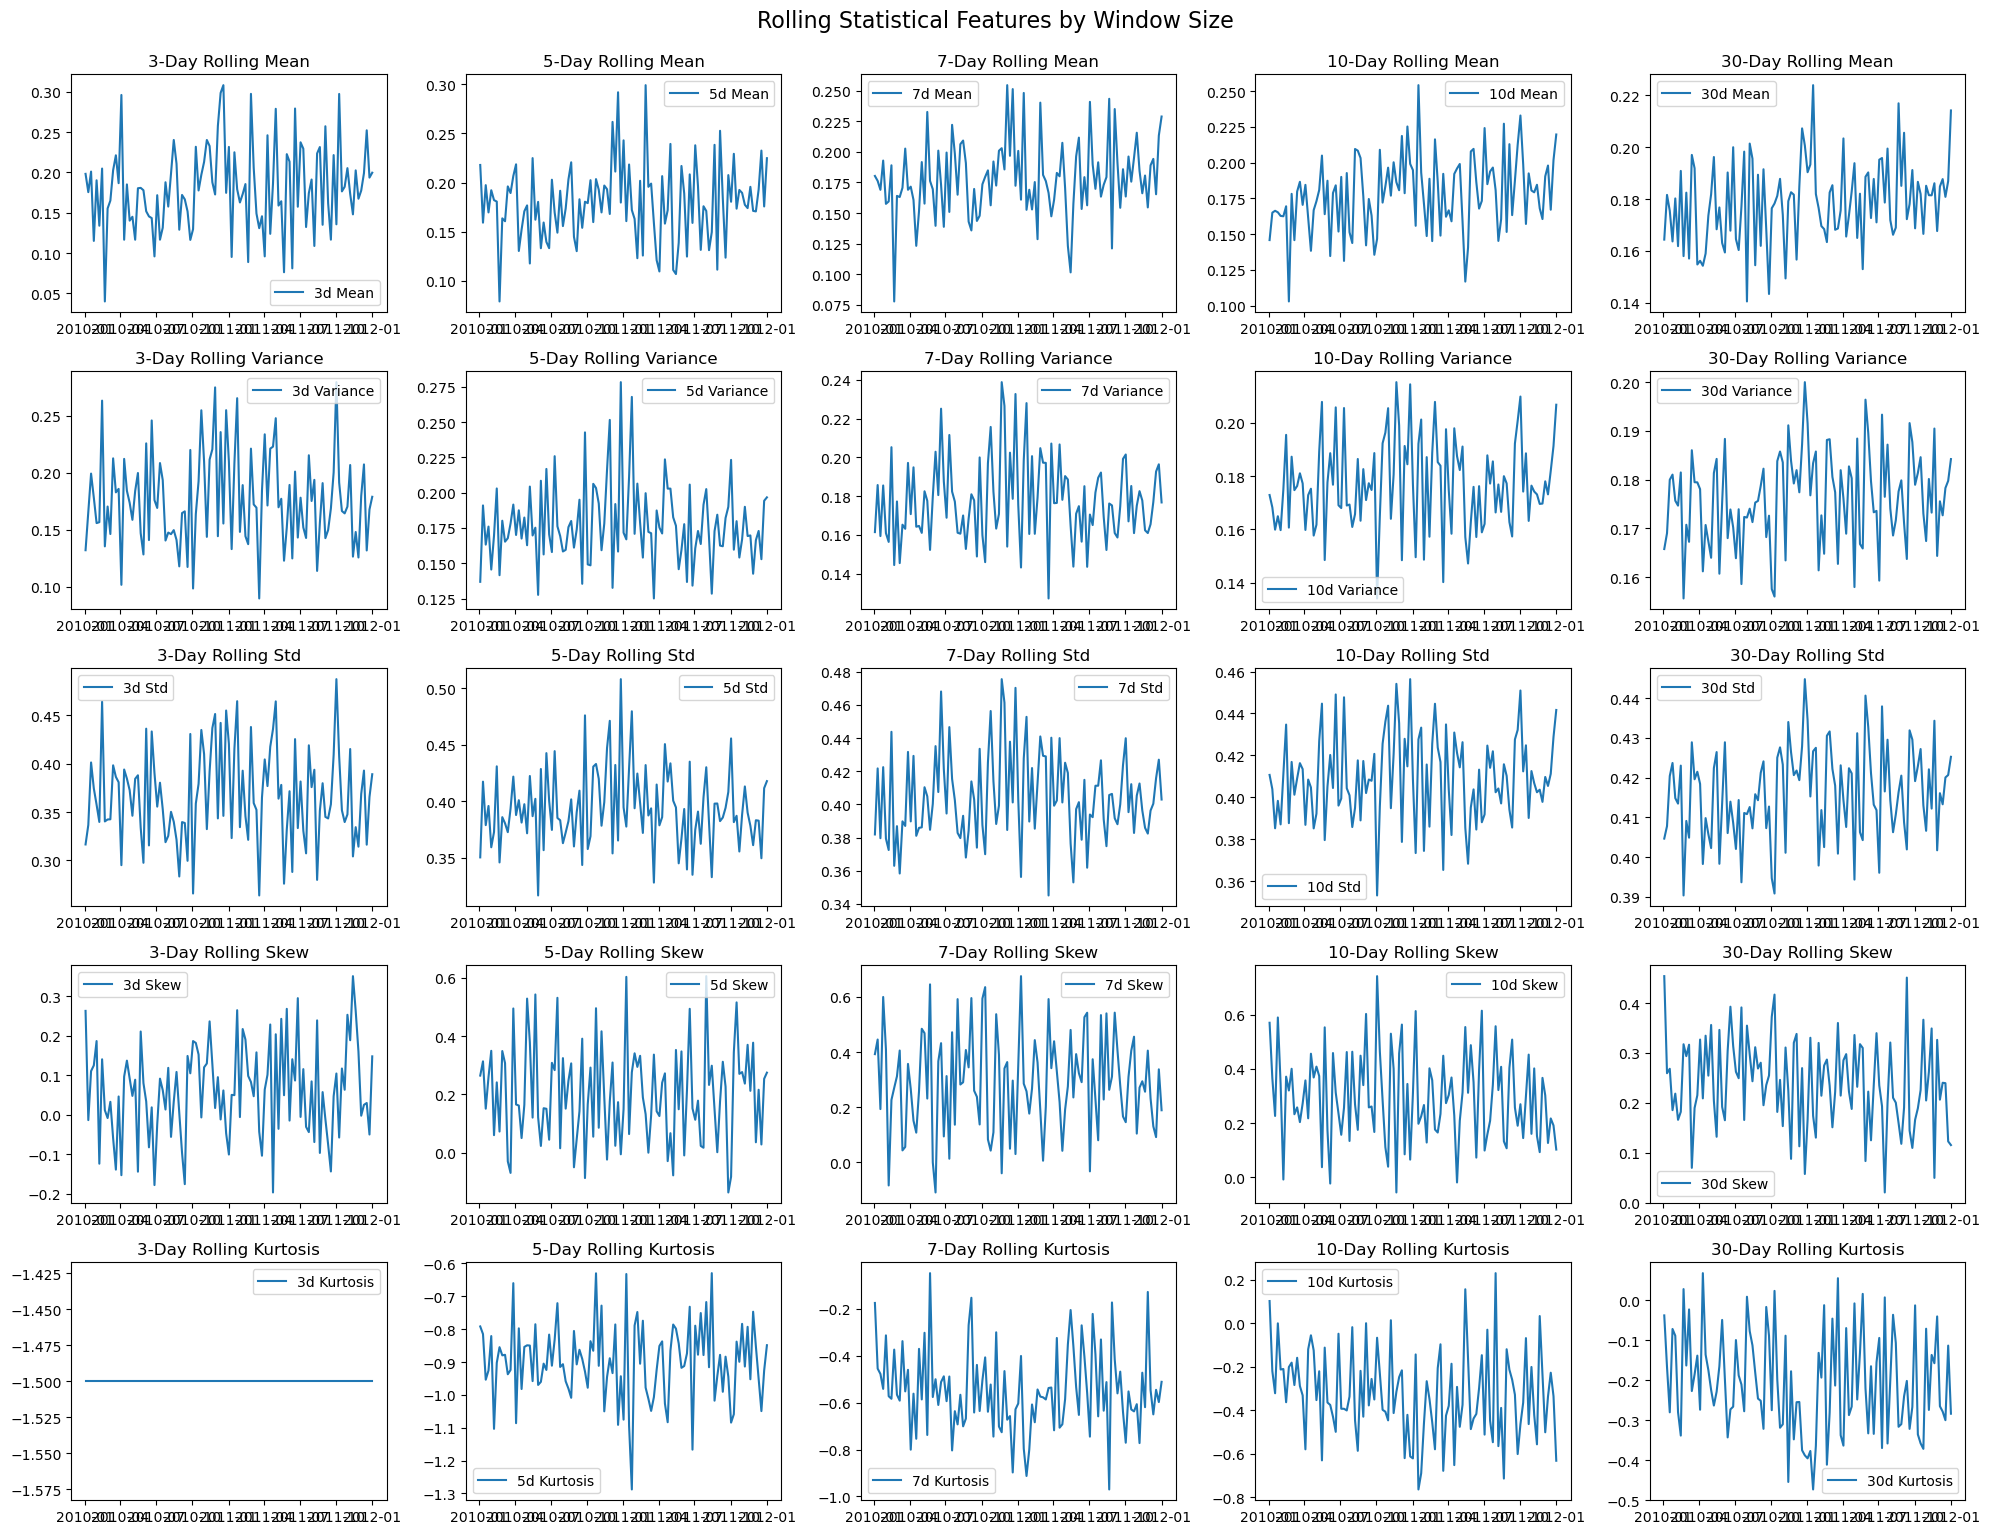

In [15]:
import matplotlib.pyplot as plt

# Define rolling window sizes and statistical metrics
rolling_windows = [3, 5, 7, 10, 30]
metrics = ['mean', 'variance', 'std', 'skew', 'kurtosis']

# Determine the number of rows and columns for subplots
# Each row represents a different metric, each column a different window size
num_rows = len(metrics)
num_cols = len(rolling_windows)

# Set figure size dynamically based on number of plots (wider and taller for more plots)
plt.figure(figsize=(4 * num_cols, 3 * num_rows))

# Initialize subplot number counter
plot_num = 1

# Loop through each metric and window size
for metric in metrics:
    for w in rolling_windows:
        col_name = f'rolling_{metric}_{w}d'  # Construct column name like 'rolling_mean_3d'
        
        # Check if this column exists in the DataFrame (avoid KeyErrors)
        if col_name in weekly_df.columns:
            # Create a subplot in the grid
            plt.subplot(num_rows, num_cols, plot_num)
            
            # Plot the rolling metric over time
            plt.plot(
                weekly_df.index, 
                weekly_df[col_name], 
                label=f'{w}d {metric.title()}', 
                color='tab:blue'
            )
            
            # Set title for each subplot
            plt.title(f'{w}-Day Rolling {metric.title()}')
            
            # Automatically adjust spacing to prevent overlap
            plt.tight_layout()
            
            # Show legend (helpful if multiple lines are added later)
            plt.legend()
            
            # Move to the next subplot
            plot_num += 1

# Set a main title for the entire figure
plt.suptitle('Rolling Statistical Features by Window Size', fontsize=16, y=1.02)

# Display the entire plot
plt.show()


### Pairplots

C:\Users\mhfah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mhfah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mhfah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mhfah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

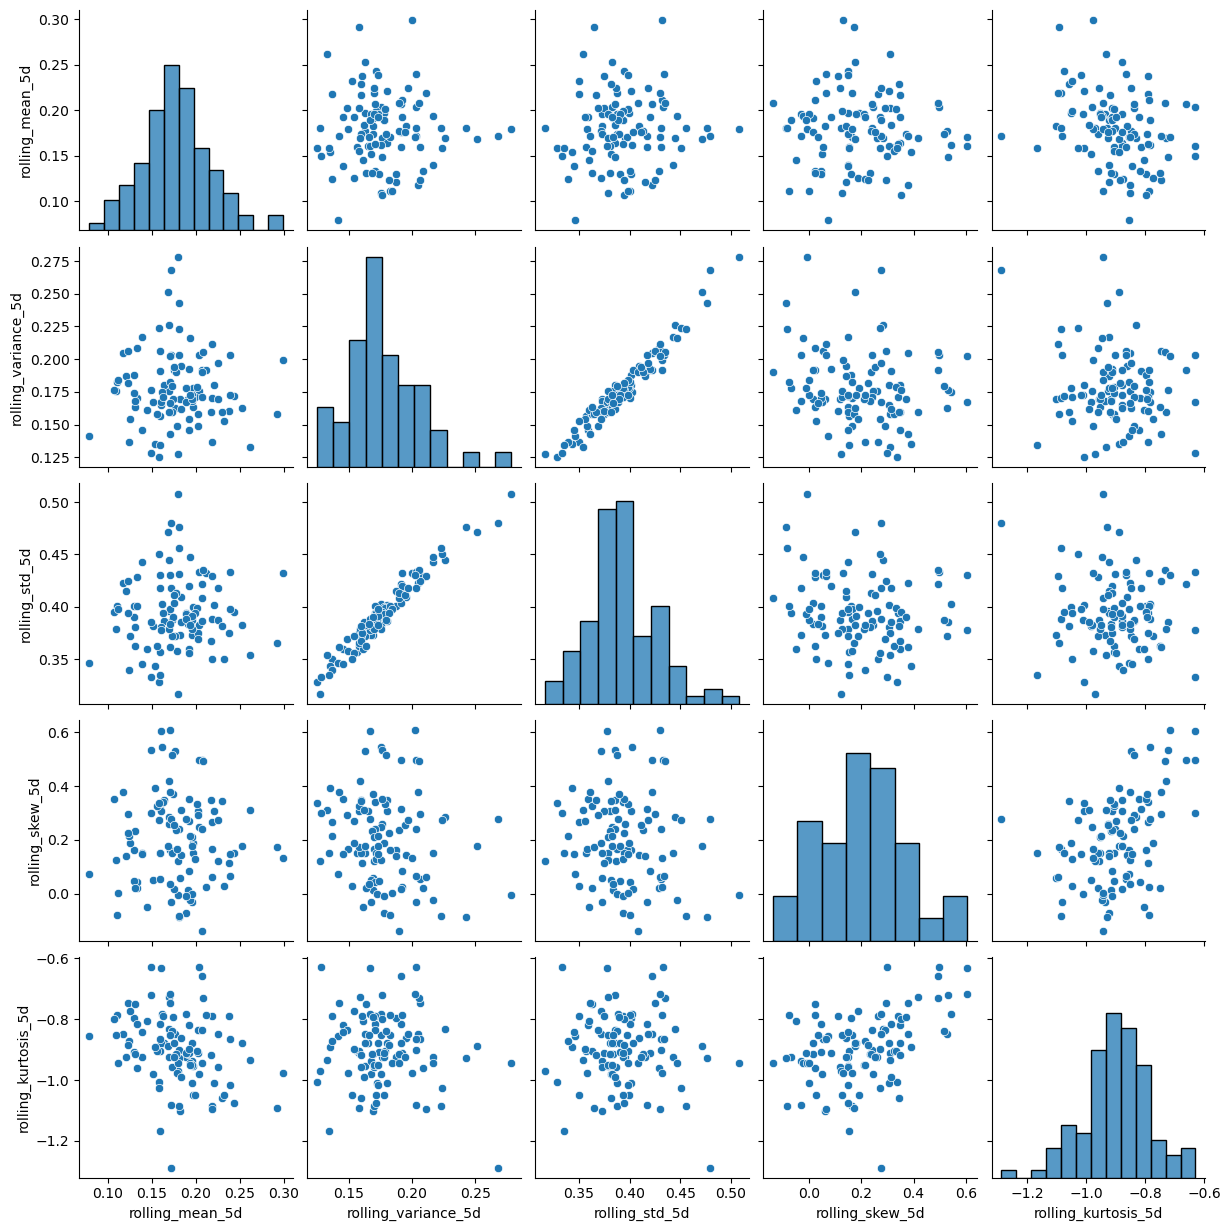

In [16]:
sns.pairplot(weekly_df[[
    'rolling_mean_5d', 'rolling_variance_5d', 'rolling_std_5d', 'rolling_skew_5d', 'rolling_kurtosis_5d'
]].dropna())


##### To visualize how different rolling statistical features (mean, variance, standard deviation, skewness, and kurtosis) are correlated with each ##### other across various rolling window sizes (3, 5, 7, 10, 30 days) using heatmaps.

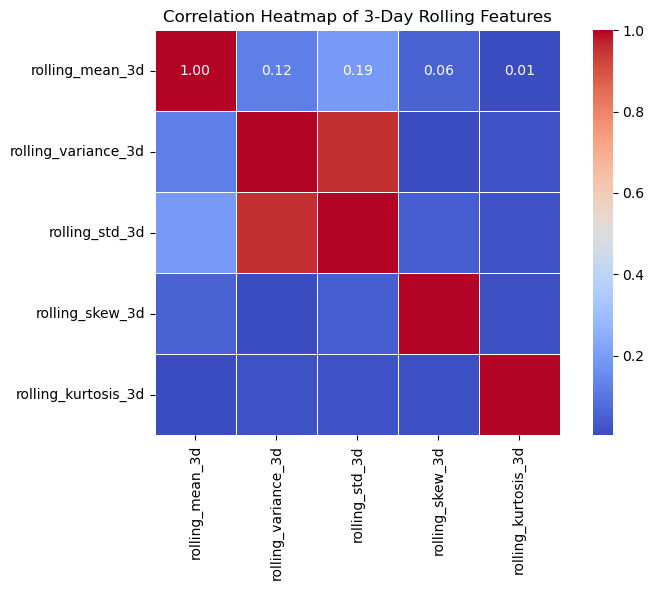

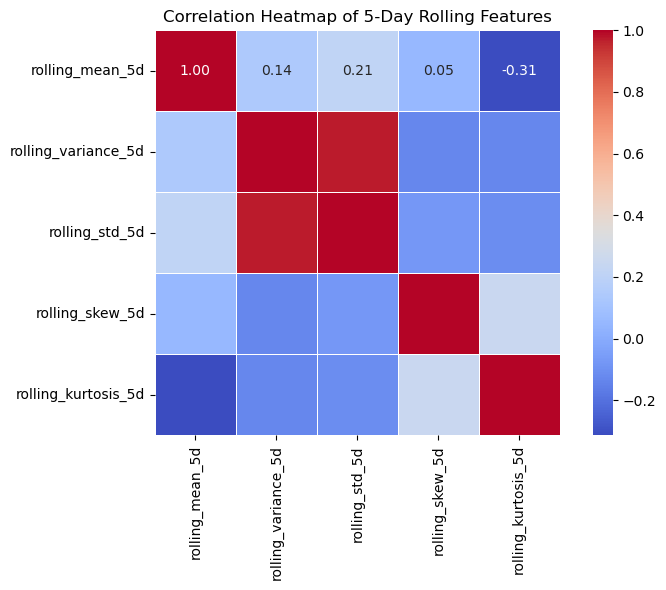

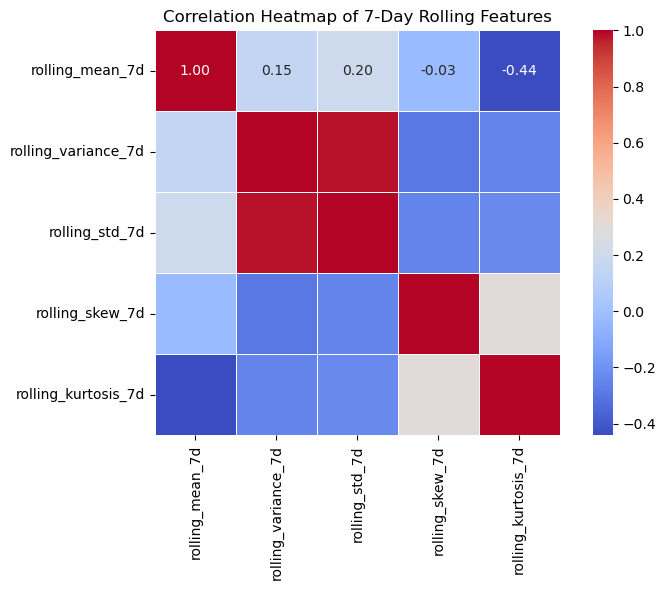

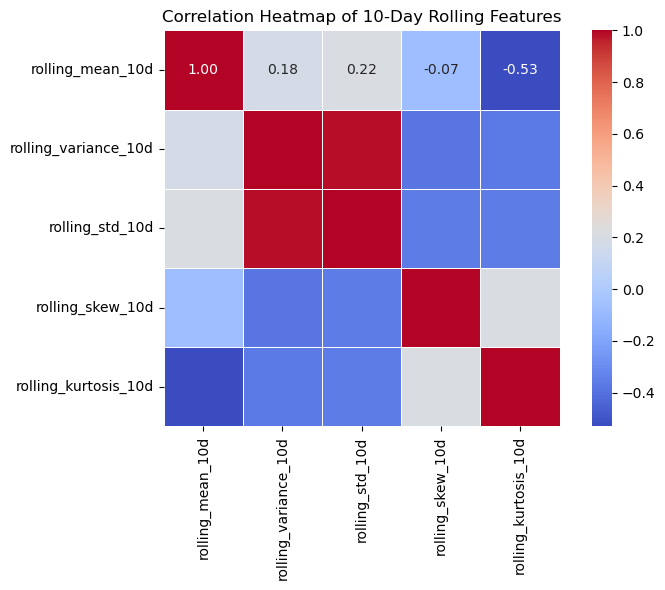

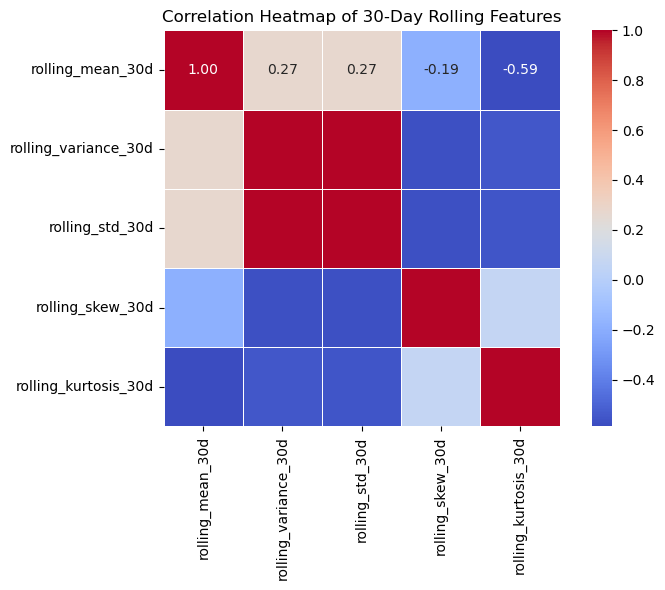

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the rolling window sizes to analyze
windows = [3, 5, 7, 10, 30]

# Loop over each rolling window size
for w in windows:
    # Construct the list of column names for the current window size
    features = [
        f'rolling_mean_{w}d',        # Rolling mean
        f'rolling_variance_{w}d',    # Rolling variance
        f'rolling_std_{w}d',         # Rolling standard deviation
        f'rolling_skew_{w}d',        # Rolling skewness
        f'rolling_kurtosis_{w}d'     # Rolling kurtosis
    ]

    # Create a temporary DataFrame containing only the current set of features
    # Drop rows with NaN values to avoid errors in correlation computation
    df_window = df[features].dropna()

    # Compute the correlation matrix between the rolling features
    corr_matrix = df_window.corr()

    # Set up the plot for the heatmap
    plt.figure(figsize=(8, 6))  # Set figure size (width x height)

    # Create the heatmap using seaborn
    sns.heatmap(
        corr_matrix,              # Correlation matrix
        annot=True,               # Display correlation coefficients
        cmap='coolwarm',          # Color theme from blue to red
        fmt=".2f",                # Format the numbers to 2 decimal places
        square=True,              # Make cells square-shaped
        linewidths=0.5            # Thin lines between cells
    )

    # Set the title for the current heatmap
    plt.title(f"Correlation Heatmap of {w}-Day Rolling Features")

    # Automatically adjust layout to prevent overlap
    plt.tight_layout()

    # Display the heatmap
    plt.show()



In [19]:
# Define the rolling window sizes to analyze
windows = [3, 5, 7, 10, 30]

# Loop through each window size
for w in windows:
    # Define the column names for the current rolling window
    features = [
        f'rolling_mean_{w}d',        # Rolling mean
        f'rolling_variance_{w}d',    # Rolling variance
        f'rolling_std_{w}d',         # Rolling standard deviation
        f'rolling_skew_{w}d',        # Rolling skewness
        f'rolling_kurtosis_{w}d'     # Rolling kurtosis
    ]

    # Extract those columns and drop any rows with NaN values
    # This ensures accurate correlation calculations (NaNs can distort results)
    df_window = df[features].dropna()

    # Calculate the correlation matrix for the current set of features
    corr_matrix = df_window.corr()

    # Print a header to indicate which window size this matrix corresponds to
    print(f"\n📊 Correlation Matrix for {w}-Day Rolling Window:\n")

    # Print the correlation matrix, rounding to 2 decimal places for readability
    print(corr_matrix.round(2))



📊 Correlation Matrix for 3-Day Rolling Window:

                     rolling_mean_3d  rolling_variance_3d  rolling_std_3d  \
rolling_mean_3d                 1.00                 0.12            0.19   
rolling_variance_3d             0.12                 1.00            0.96   
rolling_std_3d                  0.19                 0.96            1.00   
rolling_skew_3d                 0.06                 0.00            0.04   
rolling_kurtosis_3d             0.01                 0.02            0.02   

                     rolling_skew_3d  rolling_kurtosis_3d  
rolling_mean_3d                 0.06                 0.01  
rolling_variance_3d             0.00                 0.02  
rolling_std_3d                  0.04                 0.02  
rolling_skew_3d                 1.00                 0.01  
rolling_kurtosis_3d             0.01                 1.00  

📊 Correlation Matrix for 5-Day Rolling Window:

                     rolling_mean_5d  rolling_variance_5d  rolling_std_5d  \
ro

##### To calculate and print how strongly each statistical feature (variance, std, skew, kurtosis) is correlated with the rolling mean across different rolling window sizes (3, 5, 7, 10, 30 days).

In [20]:
# Loop through each rolling window size
for w in windows:
    # Define the column name for the rolling mean for this window size
    feature = f'rolling_mean_{w}d'
    
    # Define the full list of rolling statistical feature columns for this window
    features = [
        f'rolling_mean_{w}d',        # Rolling mean (target for correlation)
        f'rolling_variance_{w}d',    # Rolling variance
        f'rolling_std_{w}d',         # Rolling standard deviation
        f'rolling_skew_{w}d',        # Rolling skewness
        f'rolling_kurtosis_{w}d'     # Rolling kurtosis
    ]
    
    # Subset the DataFrame to include only these columns and drop rows with missing values
    df_window = df[features].dropna()
    
    # Compute correlation matrix for the current set of features
    corr_with_mean = df_window.corr()[feature]  # Get correlation of all with rolling_mean
    corr_with_mean = corr_with_mean.drop(feature)  # Drop self-correlation (always 1.0)
    
    # Print results with window size label and rounded for readability
    print(f"\n🔍 Correlation with {feature} (Window {w}d):")
    print(corr_with_mean.round(2))



🔍 Correlation with rolling_mean_3d (Window 3d):
rolling_variance_3d    0.12
rolling_std_3d         0.19
rolling_skew_3d        0.06
rolling_kurtosis_3d    0.01
Name: rolling_mean_3d, dtype: float64

🔍 Correlation with rolling_mean_5d (Window 5d):
rolling_variance_5d    0.14
rolling_std_5d         0.21
rolling_skew_5d        0.05
rolling_kurtosis_5d   -0.31
Name: rolling_mean_5d, dtype: float64

🔍 Correlation with rolling_mean_7d (Window 7d):
rolling_variance_7d    0.15
rolling_std_7d         0.20
rolling_skew_7d       -0.03
rolling_kurtosis_7d   -0.44
Name: rolling_mean_7d, dtype: float64

🔍 Correlation with rolling_mean_10d (Window 10d):
rolling_variance_10d    0.18
rolling_std_10d         0.22
rolling_skew_10d       -0.07
rolling_kurtosis_10d   -0.53
Name: rolling_mean_10d, dtype: float64

🔍 Correlation with rolling_mean_30d (Window 30d):
rolling_variance_30d    0.27
rolling_std_30d         0.27
rolling_skew_30d       -0.19
rolling_kurtosis_30d   -0.59
Name: rolling_mean_30d, dtype:

##### message volume

In [26]:
# Step 1: Count messages per day
message_volume = df.groupby(df.index.date).size().rename('message_volume')

# Step 2: Add daily date as a new column (as Series)
df['daily'] = pd.Series(df.index.date, index=df.index)

# Step 3: Map the message volume to each row
df['message_volume'] = df['daily'].map(message_volume)


In [33]:
# Step 1: Extract day of the week (e.g., Monday=0, Sunday=6)
df['day_of_the_week'] = df.index.dayofweek

# Step 2: Mark weekends (Saturday=5, Sunday=6)
df['is_weekend'] = df['day_of_the_week'].isin([5, 6]).astype(int)


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2191 entries, 2010-05-10 to 2010-10-30
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype        
---  ------                --------------  -----        
 0   Subject               2191 non-null   object       
 1   body                  2191 non-null   object       
 2   from                  2191 non-null   object       
 3   roberta_neg           2191 non-null   float64      
 4   roberta_neu           2191 non-null   float64      
 5   roberta_pos           2191 non-null   float64      
 6   label                 2191 non-null   object       
 7   weekly                2191 non-null   period[W-SUN]
 8   sentiment_score       2191 non-null   float64      
 9   rolling_variance_3d   2189 non-null   float64      
 10  rolling_mean_3d       2189 non-null   float64      
 11  rolling_std_3d        2189 non-null   float64      
 12  rolling_skew_3d       2189 non-null   float64      
 13  rolling_kurtosi

#### Feature Engineering

In [28]:


feature_columns = [
    'rolling_mean_3d', 'rolling_variance_3d', 'rolling_std_3d', 'rolling_skew_3d', 'rolling_kurtosis_3d',
    'rolling_mean_5d', 'rolling_variance_5d', 'rolling_std_5d', 'rolling_skew_5d', 'rolling_kurtosis_5d',
    'rolling_mean_7d', 'rolling_variance_7d', 'rolling_std_7d', 'rolling_skew_7d', 'rolling_kurtosis_7d',
    'rolling_mean_10d', 'rolling_variance_10d', 'rolling_std_10d', 'rolling_skew_10d', 'rolling_kurtosis_10d',
    'rolling_mean_30d', 'rolling_variance_30d', 'rolling_std_30d', 'rolling_skew_30d', 'rolling_kurtosis_30d',
    'day_of_the_week' , 'is_weekend', 'message_volume'
]



In [38]:
# Create lagged features for sentiment_score
# Each lag represents the sentiment score from previous time steps (e.g., 1 day ago, 2 days ago, etc.)
df['sentiment_lag_1'] = df['sentiment_score'].shift(1)  # Shift by 1: yesterday's sentiment
df['sentiment_lag_2'] = df['sentiment_score'].shift(2)  # Shift by 2: 2 days ago
df['sentiment_lag_3'] = df['sentiment_score'].shift(3)  # Shift by 3: 3 days ago

# Store the names of the lagged features in a list
lag_features = ['sentiment_lag_1', 'sentiment_lag_2', 'sentiment_lag_3']

# Combine lagged features with previously defined rolling features (feature_columns should be defined earlier)
# This creates a full set of features for model input
all_features = feature_columns + lag_features


In [40]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

# Select features and target columns
X = df[all_features]
y = df['sentiment_score']

# Combine into one DataFrame to drop any row with NaN in either features or target
data = pd.concat([X, y], axis=1)

# Drop rows with any NA
data = data.dropna()

# Now split features and target again
X_clean = data[all_features]
y_clean = data['sentiment_score']

# Now train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

rf_model.fit(X_train, y_train)

# Create a pandas Series from the feature importances of the trained Random Forest model
# Use the column names from the training data (X_train) as the index
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Sort the feature importances in descending order (most important first)
importances = importances.sort_values(ascending=False)

# Print a header for clarity
print("Feature importances:")

# Print the sorted list of feature importances
print(importances)


Feature importances:
rolling_mean_3d         0.382804
sentiment_lag_2         0.186264
sentiment_lag_1         0.159560
rolling_std_3d          0.077701
rolling_skew_3d         0.075626
rolling_variance_3d     0.066684
rolling_variance_5d     0.004358
rolling_std_5d          0.003933
rolling_skew_5d         0.003453
rolling_mean_5d         0.003245
rolling_variance_7d     0.002802
rolling_skew_30d        0.002711
rolling_skew_10d        0.002599
rolling_kurtosis_5d     0.002368
rolling_std_10d         0.002225
rolling_skew_7d         0.002217
rolling_mean_7d         0.002079
rolling_kurtosis_10d    0.002071
rolling_mean_10d        0.001914
rolling_kurtosis_7d     0.001903
rolling_variance_10d    0.001889
rolling_mean_30d        0.001770
rolling_kurtosis_30d    0.001749
rolling_std_7d          0.001747
sentiment_lag_3         0.001680
rolling_std_30d         0.001327
rolling_variance_30d    0.001066
message_volume          0.001039
day_of_the_week         0.000997
is_weekend            

#### feature Isolaton test

In [43]:
for feature in all_features:
    # Select the current feature column and copy it to avoid modifying the original df
    data = df[[feature]].copy()
    
    # Add the target variable 'y' as a new column named 'target'
    data['sentiment_score'] = y
    
    # Drop rows where either the feature or the target has NaN values
    # This is important because lagged and rolling features often contain NaNs at the start
    data = data.dropna()

    # Define feature matrix X_single with the current feature (after dropping NaNs)
    X_single = data[[feature]]
    
    # Define target vector y_single corresponding to the cleaned dataset
    y_single = data['sentiment_score']

    # Split data into training and testing sets (80% train, 20% test)
    # random_state=42 ensures reproducibility of the split
    X_train, X_test, y_train, y_test = train_test_split(X_single, y_single, test_size=0.2, random_state=42)

    # Initialize a Linear Regression model
    lr = LinearRegression()
    
    # Train the model on training data
    lr.fit(X_train, y_train)
    
    # Predict the target variable on the test set
    y_pred_test = lr.predict(X_test)
    
    # Compute and print the R² score, showing how well the single feature predicts the target
    print(f"{feature} Test R2: {r2_score(y_test, y_pred_test)}")


rolling_mean_3d Test R2: 0.33394280070453153
rolling_variance_3d Test R2: -0.0017879457625396
rolling_std_3d Test R2: 0.0012096808098460698
rolling_skew_3d Test R2: -0.0028295092933778854
rolling_kurtosis_3d Test R2: -0.0041937901574971015
rolling_mean_5d Test R2: 0.17361201318888186
rolling_variance_5d Test R2: -0.005848133343909545
rolling_std_5d Test R2: -0.0009344024697357511
rolling_skew_5d Test R2: -0.0017755200992790598
rolling_kurtosis_5d Test R2: -0.004064980645734906
rolling_mean_7d Test R2: 0.11662466735551813
rolling_variance_7d Test R2: -0.01086117741185788
rolling_std_7d Test R2: -0.006509030286593109
rolling_skew_7d Test R2: 0.0016500497958610305
rolling_kurtosis_7d Test R2: -0.0030898597448636433
rolling_mean_10d Test R2: 0.08666741937420108
rolling_variance_10d Test R2: -0.009858139121991405
rolling_std_10d Test R2: -0.007106861870492587
rolling_skew_10d Test R2: 0.0005892375993303833
rolling_kurtosis_10d Test R2: 0.01552757324875309
rolling_mean_30d Test R2: 0.0327257

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# List of best features selected based on previous analysis where R2 > 0,
# meaning these features individually showed some predictive power
best_features = [
    'rolling_mean_3d',
    'rolling_mean_5d',
    'rolling_mean_7d',
    'rolling_mean_10d',
    'rolling_mean_30d',
    'rolling_variance_30d',
    'rolling_std_30d',
    'rolling_skew_30d',
    'rolling_kurtosis_10d',
    'rolling_kurtosis_30d',
    'rolling_skew_7d',
    'rolling_skew_10d'
]

# Create a DataFrame containing only the best features and the target ('sentiment_score')
# Drop rows with any NaN values to avoid errors during model training/testing
df_model = df[best_features + ['sentiment_score']].dropna()

# Define feature matrix X and target vector y
X = df_model[best_features]
y = df_model['sentiment_score']

# Split data into training (80%) and testing (20%) sets, with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model using the training data
lr.fit(X_train, y_train)

# Predict sentiment scores for the test data
y_pred = lr.predict(X_test)

# Calculate and print the R² score to evaluate the combined predictive power of all best features
print(f"Combined features Test R2: {r2_score(y_test, y_pred)}")


Combined features Test R2: 0.3293482715896512


In [45]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on training data
y_pred_train = lr.predict(X_train)

# Predict on testing data
y_pred_test = lr.predict(X_test)

# Calculate and print training metrics
print("Train MSE:", mean_squared_error(y_train, y_pred_train))
print("Train R2:", r2_score(y_train, y_pred_train))

# Calculate and print testing metrics
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print("Test R2:", r2_score(y_test, y_pred_test))


Train MSE: 0.1182489409008472
Train R2: 0.3354029107248233
Test MSE: 0.11048293416368563
Test R2: 0.3293482715896512


### Implementing LassoCV to obtain best features

In [48]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define target and features
target_column = 'sentiment_score'  
X = df[best_features]
y = df[target_column]

# Drop rows where any of the selected features or target is NaN
df_clean = pd.concat([X, y], axis=1).dropna()

X_clean = df_clean[best_features]
y_clean = df_clean[target_column]

# Split after cleaning
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Initialize and fit LassoCV
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Selected features by Lasso (non-zero coefficients)
selected_features_lasso = [f for f, coef in zip(X_clean.columns, lasso.coef_) if coef != 0]
print("Lasso selected features:", selected_features_lasso)

# Evaluate performance
print("Test R2:", r2_score(y_test, lasso.predict(X_test)))


Lasso selected features: ['rolling_mean_3d', 'rolling_kurtosis_10d', 'rolling_skew_7d', 'rolling_skew_10d']
Test R2: 0.3354418882128145


#### fine-tuning lassocv with differernt aplha values

In [49]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Define the parameter grid for alpha (regularization strength)
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize the Lasso model
lasso = Lasso(random_state=42, max_iter=10000)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best alpha found by GridSearchCV
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Best Lasso model
best_lasso = grid_search.best_estimator_

# Predict on test set
y_pred = best_lasso.predict(X_test)

# Evaluation metrics
print("Test R2:", r2_score(y_test, y_pred))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Selected features by best Lasso (non-zero coefficients)
selected_features = [f for f, coef in zip(X_train.columns, best_lasso.coef_) if coef != 0]
print("Selected features by Lasso:", selected_features)


Best alpha: 0.001
Test R2: 0.33392988442289573
Test MAE: 0.2602209894405498
Test RMSE: 0.33125241259130206
Selected features by Lasso: ['rolling_mean_3d', 'rolling_mean_7d', 'rolling_kurtosis_10d', 'rolling_skew_7d', 'rolling_skew_10d']


#### Metrics

In [50]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# Define scorers for MAE and RMSE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # negative because sklearn maximizes scores
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Initialize Lasso with chosen alpha or use LassoCV internally (example with fixed alpha)
lasso = LassoCV(cv=5, random_state=42)

# Combine features and target, drop missing values
df_clean = df[best_features + [target_column]].dropna()
X_clean = df_clean[best_features]
y_clean = df_clean[target_column]

# Perform cross-validation
cv_results = cross_validate(
    lasso, X_clean, y_clean,
    cv=5,
    scoring={'r2': 'r2', 'neg_mae': mae_scorer, 'neg_rmse': rmse_scorer},
    return_train_score=False
)

# Convert negative scores back to positive errors
mae_scores = -cv_results['test_neg_mae']
rmse_scores = -cv_results['test_neg_rmse']

print(f"Average CV R2: {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
print(f"Average CV MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
print(f"Average CV RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")


Average CV R2: 0.3321 ± 0.0258
Average CV MAE: 0.2711 ± 0.0079
Average CV RMSE: 0.3418 ± 0.0110


In [51]:
import joblib

# Save the model to a file
joblib_file = "lasso_model.pkl"
joblib.dump(lasso, joblib_file)

print(f"Model saved to {joblib_file}")


Model saved to lasso_model.pkl


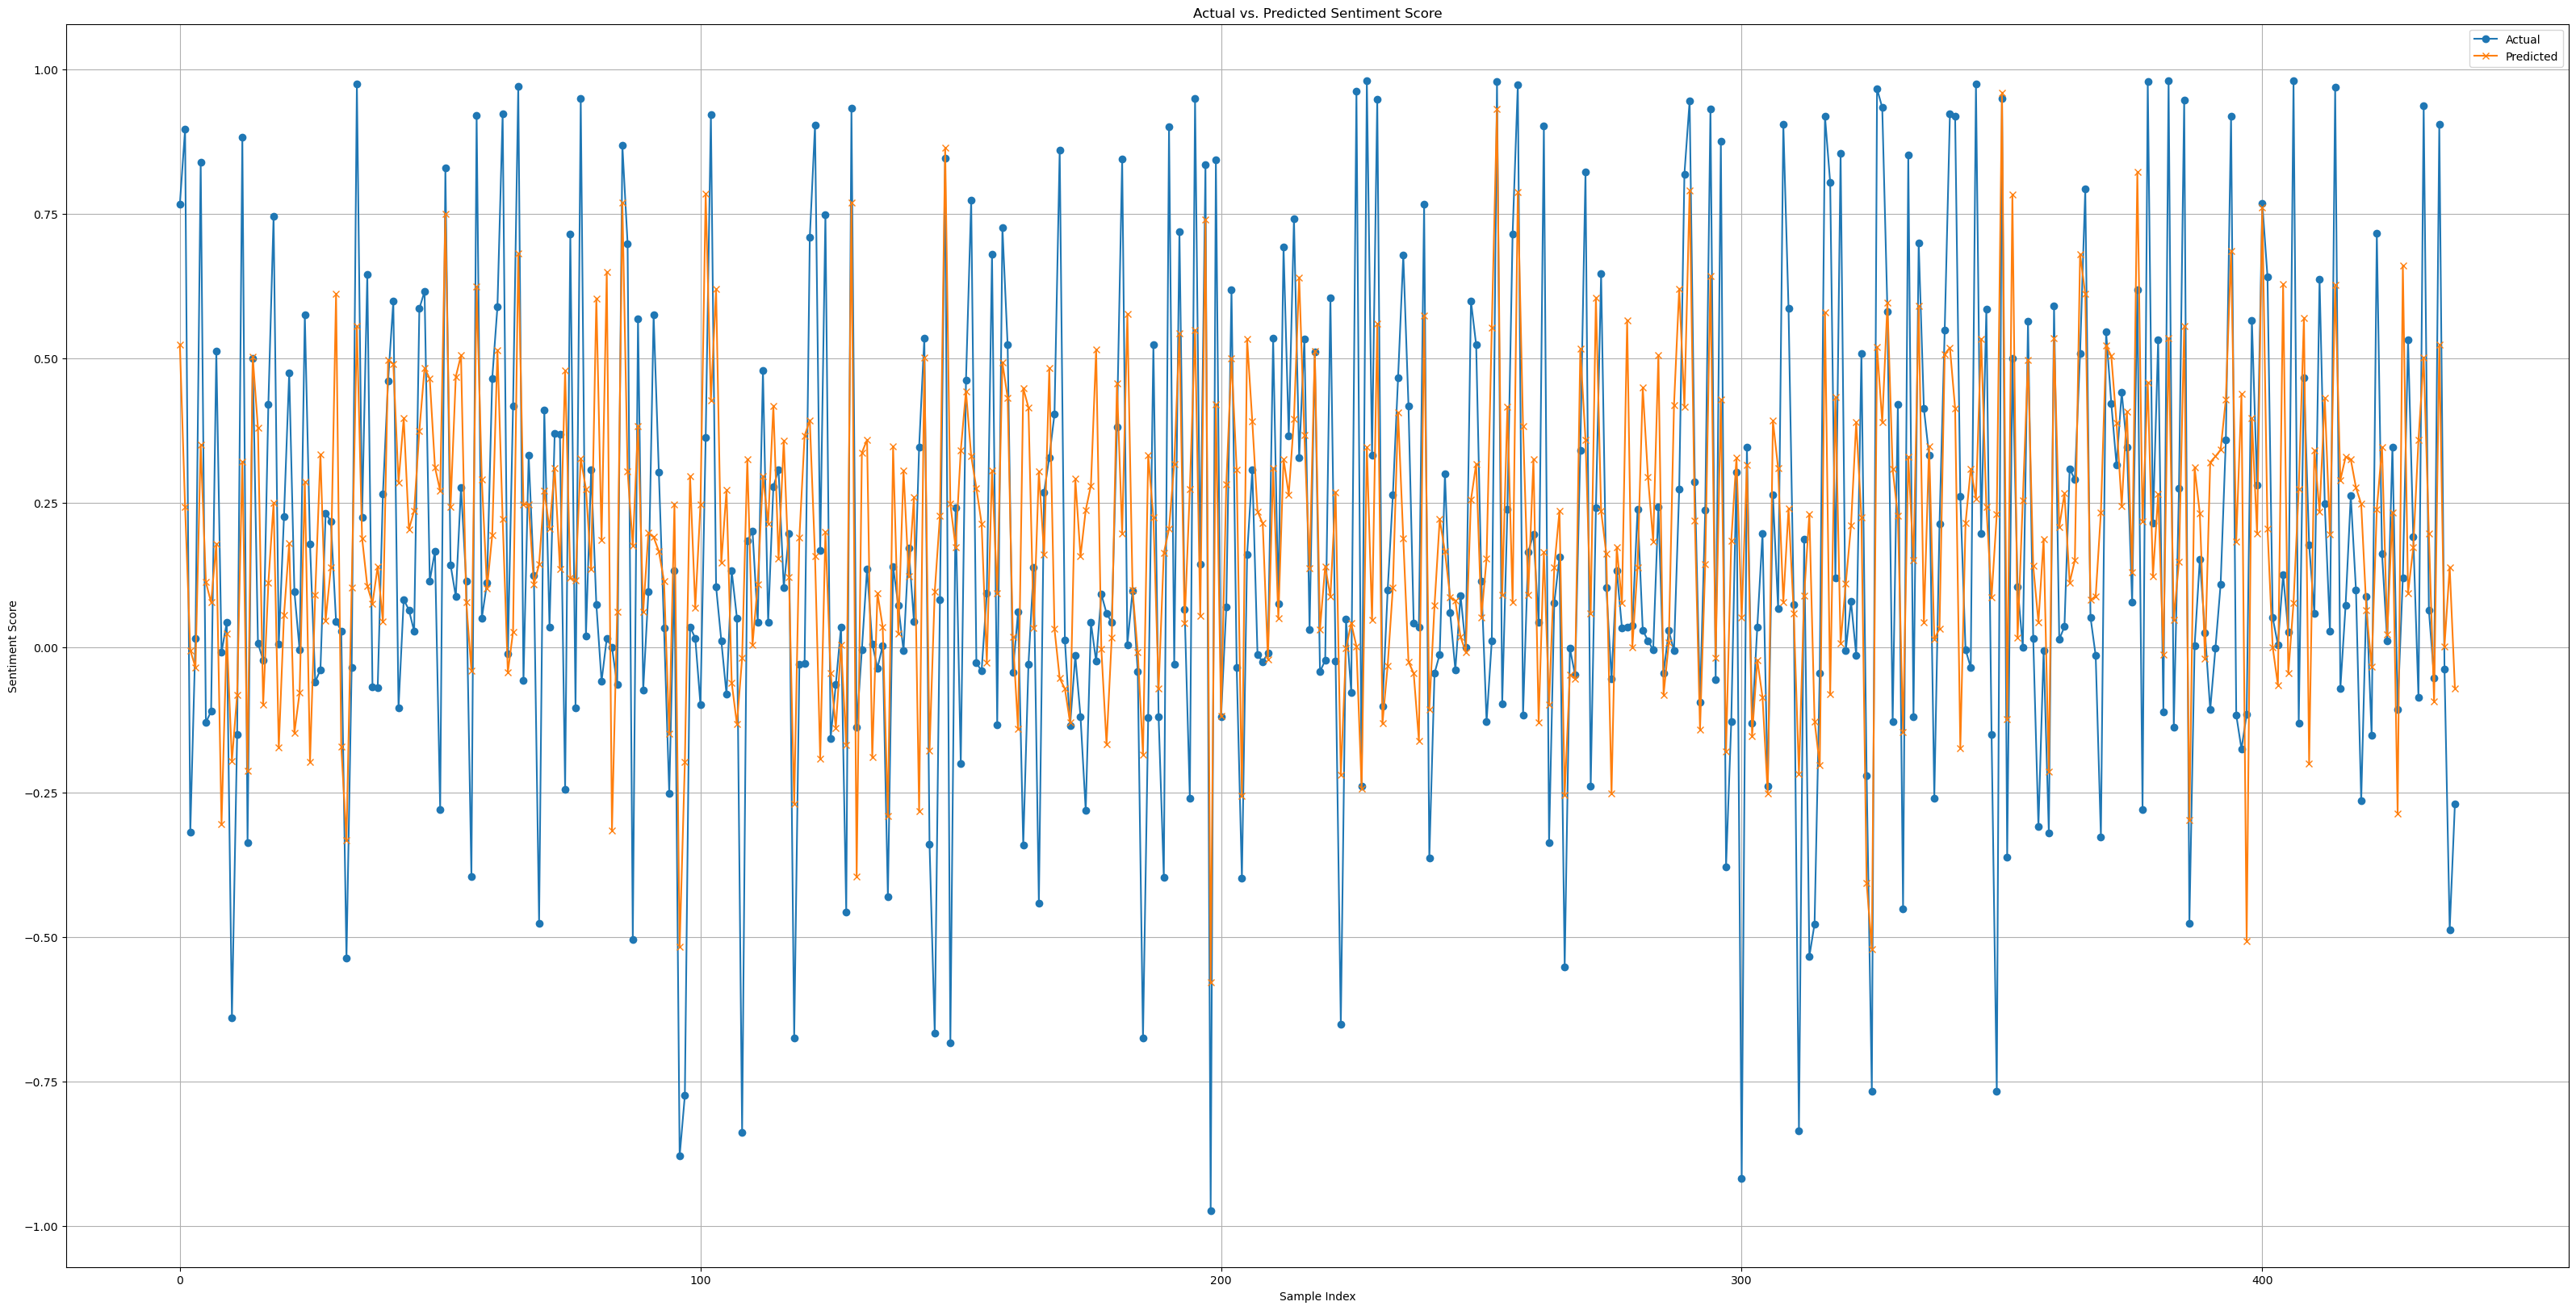

In [70]:

plt.figure(figsize=(40, 20))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs. Predicted Sentiment Score')
plt.xlabel('Sample Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
df.head(10)

,Subject,body,from,roberta_neg,roberta_neu,roberta_pos,label,weekly,sentiment_score,rolling_variance_3d,...,rolling_kurtosis_10d,rolling_variance_30d,rolling_mean_30d,rolling_std_30d,rolling_skew_30d,rolling_kurtosis_30d,daily,message_volume,day_of_the_week,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2010-05-10,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,sally.beck@enron.com,0.012207,0.492302,0.495490,positive,2010-05-10/2010-05-16,0.483283,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2010-05-10,4,0,0
2010-07-29,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",eric.bass@enron.com,0.653594,0.316744,0.029662,negative,2010-07-26/2010-08-01,-0.623932,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2010-07-29,5,3,0
2011-07-25,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",sally.beck@enron.com,0.043858,0.908734,0.047408,neutral,2011-07-25/2011-07-31,0.003550,0.308301,...,-1.500000,0.308301,-0.045700,0.555248,-0.161668,-1.500000,2011-07-25,2,0,0
2010-03-25,RE: My new work email,we were thinking papasitos (we can meet somewh...,johnny.palmer@enron.com,0.023093,0.845511,0.131396,neutral,2010-03-22/2010-03-28,0.108302,0.156812,...,-0.985068,0.211463,-0.007199,0.459851,-0.455357,-0.985068,2010-03-25,3,3,0
2011-05-21,Bet,Since you never gave me the $20 for the last t...,lydia.delgado@enron.com,0.241674,0.686705,0.071622,neutral,2011-05-16/2011-05-22,-0.170052,0.019765,...,-0.765692,0.163901,-0.039770,0.404847,-0.232215,-0.765692,2011-05-21,6,5,1
2011-10-23,RE: Favor,"sure, just call me the bank that delivers.\n \...",eric.bass@enron.com,0.041024,0.814124,0.144852,neutral,2011-10-17/2011-10-23,0.103829,0.025419,...,-0.351480,0.134558,-0.015837,0.366821,-0.446333,-0.351480,2011-10-23,4,6,1
2010-04-05,MG Inventory Summaries,Inventory summaries for both MGL and MGMCC as ...,kayne.coulter@enron.com,0.058766,0.906897,0.034337,neutral,2010-04-05/2010-04-11,-0.024429,0.018778,...,0.081820,0.112142,-0.017064,0.334876,-0.470152,0.081820,2010-04-05,5,0,0
2010-04-21,Forgot the Attachment,Please print attachment and make sure that e:m...,patti.thompson@enron.com,0.025823,0.619558,0.354618,neutral,2010-04-19/2010-04-25,0.328795,0.031971,...,0.073262,0.111074,0.026168,0.333278,-0.652635,0.073262,2010-04-21,5,2,0
2010-02-07,Garvin Brown - AXIA Sr. Power Scheduler,Please advise me of your interest in Garvin's ...,sally.beck@enron.com,0.013873,0.767108,0.219019,neutral,2010-02-01/2010-02-07,0.205145,0.032127,...,0.426240,0.100749,0.046055,0.317410,-0.831749,0.426240,2010-02-07,4,6,1


## Compute a monthly sentiment score for each employee based on their messages.

In [54]:
# If your DataFrame 'df' has a datetime index, this converts it to a monthly period
# This helps group data by month (e.g., 2025-06, 2025-07)
df['month'] = df.index.to_period('M')

# Define a mapping from sentiment labels to numeric scores
# Positive → +1, Neutral → 0, Negative → -1
label_to_score = {'positive': 1, 'negative': -1, 'neutral': 0}

# Create a new 'score' column in the DataFrame based on the label mapping
df['score'] = df['label'].map(label_to_score)

# Group the data by both 'month' and 'from' (email sender), then sum the sentiment scores
# This gives you a net sentiment score per sender per month
ab = df.groupby(['month', 'from'])['score'].sum()

# Display the last 110 records from the resulting grouped data
print(ab.tail(110))


month    from                       
2011-02  bobette.riner@ipgdirect.com   -1
         don.baughman@enron.com         0
         eric.bass@enron.com            0
         john.arnold@enron.com          6
         johnny.palmer@enron.com        7
                                       ..
2011-12  kayne.coulter@enron.com        4
         lydia.delgado@enron.com        4
         patti.thompson@enron.com       3
         rhonda.denton@enron.com        4
         sally.beck@enron.com           2
Name: score, Length: 110, dtype: int64


# Task4: Employee ranking

## Generate ranked lists of employees based on their monthly sentiment scores


In [56]:
# Convert the multi-index Series 'ab' into a DataFrame with columns: 'month', 'from', and 'score'
ranked_list = ab.reset_index(name='score')

# Sort the DataFrame by 'month' (ascending) and then by 'score' (descending)
# This orders senders within each month by their highest sentiment scores first
pos_emp_ranked_list = ranked_list.sort_values(by=['month', 'score'], ascending=[True, False])

# For each month, select the top 3 senders with the highest sentiment scores
pos_emp_ranked_list = pos_emp_ranked_list.groupby('month').head(3)

# Sort the DataFrame by 'month' and then by 'score' ascending
# This orders senders by lowest sentiment scores first (most negative)
neg_emp_ranked_list = ranked_list.sort_values(by=['month', 'score'], ascending=[True, True])
print("top 3 senders with the lowest sentiment scores")
# For each month, select the top 3 senders with the lowest sentiment scores (most negative)
neg_emp_ranked_list = neg_emp_ranked_list.groupby('month').head(3)

# Print the first 50 rows of the negative ranked list (most negative senders per month)
print(neg_emp_ranked_list.head(10))
print("top 3 senders with the highest sentiment scores")
# Print the first 50 rows of the positive ranked list (most positive senders per month)
print(pos_emp_ranked_list.head(10))


top 3 senders with the lowest sentiment scores
      month                         from  score
9   2010-01         sally.beck@enron.com     -1
0   2010-01  bobette.riner@ipgdirect.com      0
3   2010-01        john.arnold@enron.com      0
15  2010-02      kayne.coulter@enron.com     -2
19  2010-02         sally.beck@enron.com     -1
13  2010-02        john.arnold@enron.com      0
21  2010-03       don.baughman@enron.com      0
25  2010-03      kayne.coulter@enron.com      0
26  2010-03      lydia.delgado@enron.com      0
32  2010-04          eric.bass@enron.com      0
top 3 senders with the highest sentiment scores
      month                         from  score
2   2010-01          eric.bass@enron.com      3
7   2010-01     patti.thompson@enron.com      3
1   2010-01       don.baughman@enron.com      2
10  2010-02  bobette.riner@ipgdirect.com      4
14  2010-02      johnny.palmer@enron.com      4
11  2010-02       don.baughman@enron.com      3
29  2010-03         sally.beck@enron.com 

### Sort them first in descending order and then in alphabetical order.

In [58]:
# Sort the positive employee ranked list:
# First, sort by 'month' in descending order (most recent month first),
# Then by 'from' (sender's name or email) in ascending alphabetical order
pos_emp_ranked_list = pos_emp_ranked_list.sort_values(by=['month', 'from'], ascending=[False, True])

# Sort the negative employee ranked list in the same way:
# Descending by month, ascending alphabetically by sender
neg_emp_ranked_list = neg_emp_ranked_list.sort_values(by=['month', 'from'], ascending=[False, True])

# Print a message indicating the order of ranking for negative senders
print('negative employee ranked first in descending order and then in alphabetical order.\n\n')

# Print the first 50 rows of the sorted negative list
print(neg_emp_ranked_list.head(5))

# Print a message indicating the order of ranking for positive senders
print('positive employee ranked first in descending order and then in alphabetical order.\n\n')

# Print the first 50 rows of the sorted positive list
print(pos_emp_ranked_list.head(5))


negative employee ranked first in descending order and then in alphabetical order.


       month                         from  score
230  2011-12  bobette.riner@ipgdirect.com     -1
231  2011-12       don.baughman@enron.com      0
234  2011-12      johnny.palmer@enron.com      0
222  2011-11          eric.bass@enron.com      1
226  2011-11      lydia.delgado@enron.com      0
positive employee ranked first in descending order and then in alphabetical order.


       month                     from  score
235  2011-12  kayne.coulter@enron.com      4
236  2011-12  lydia.delgado@enron.com      4
238  2011-12  rhonda.denton@enron.com      4
223  2011-11    john.arnold@enron.com      3
225  2011-11  kayne.coulter@enron.com      5


### negative employess Ranking chart

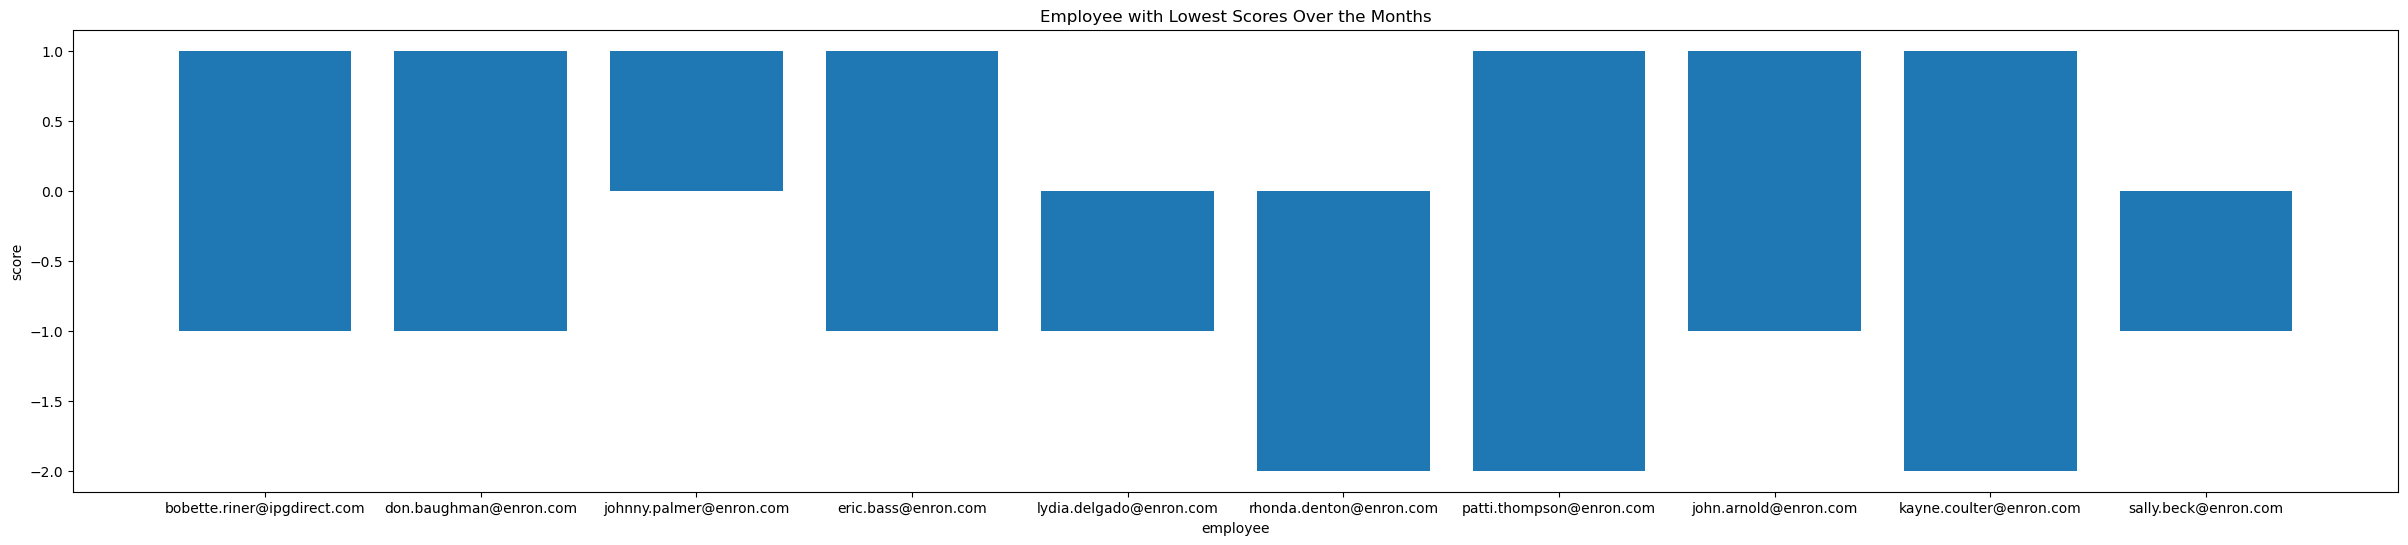

In [59]:
# Set the figure size to be wide and short (ideal for horizontal axis with many entries)
plt.figure(figsize=(30, 6))

# Create a bar chart where the x-axis is employee (sender) and y-axis is their sentiment score
plt.bar(neg_emp_ranked_list['from'], neg_emp_ranked_list['score'])

# Label x-axis as 'employee'
plt.xlabel('employee')

# Label y-axis as 'score'
plt.ylabel('score')

# Set the title of the chart
plt.title('Employee with Lowest Scores Over the Months')

# Display the plot
plt.show()

### positive employess Ranking chart

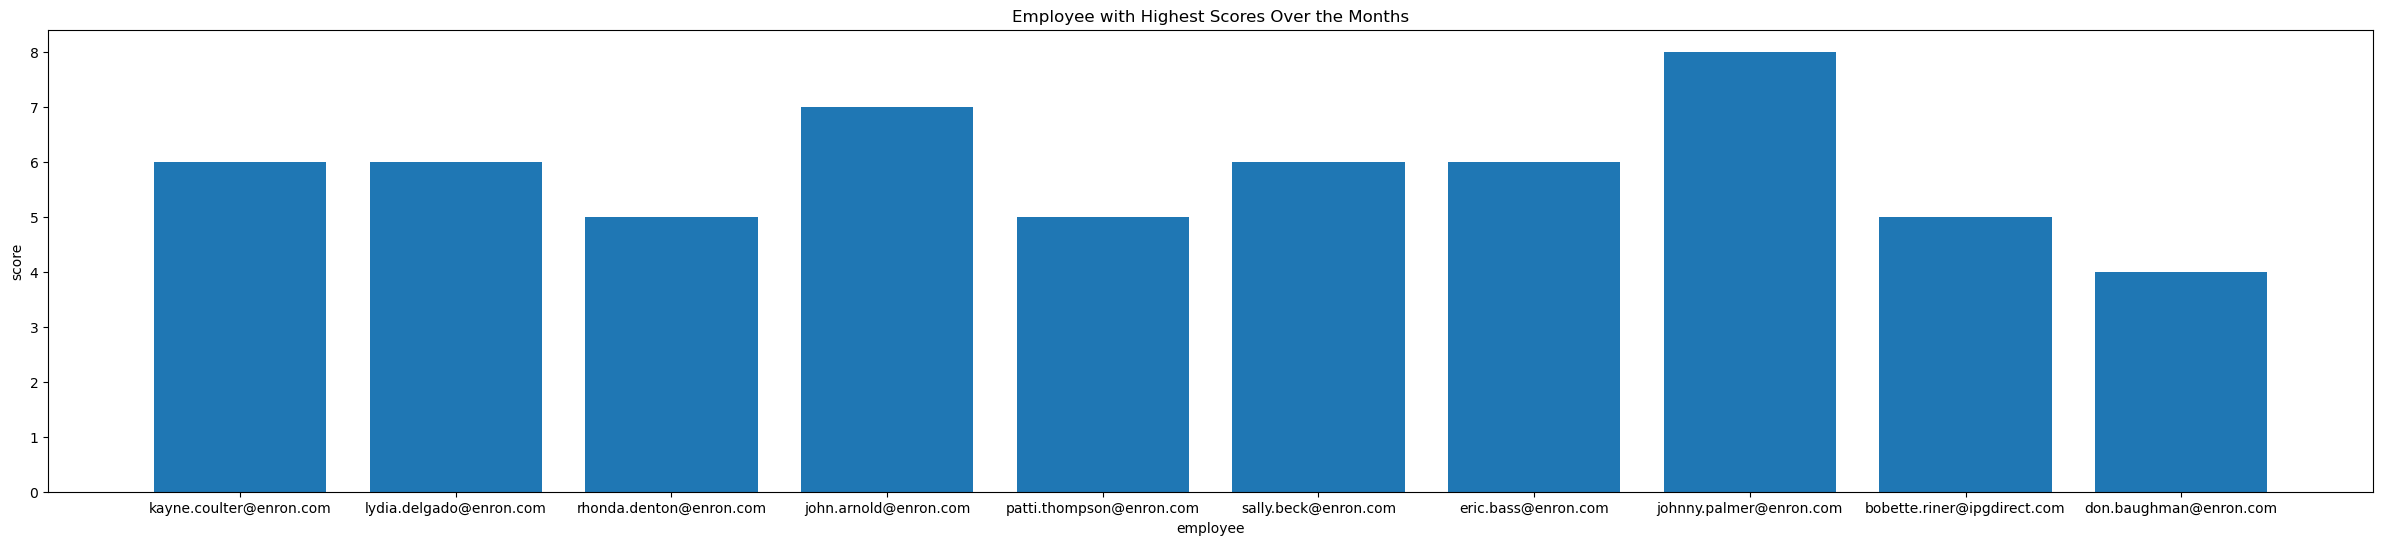

In [61]:
# Set the figure size wide for many employee names on x-axis
plt.figure(figsize=(30, 6))

# Plot a bar chart for top positive employees with their scores
plt.bar(pos_emp_ranked_list['from'], pos_emp_ranked_list['score'])

# Label the x-axis as 'employee'
plt.xlabel('employee')

# Label the y-axis as 'score'
plt.ylabel('score')

# Set the title of the chart
plt.title('Employee with Highest Scores Over the Months')

# Display the chart
plt.show()

# Task 5: Flight Risk Identification

### Objective: Identify employees who are at risk of leaving based on their monthly sentiment scores.

Identifies employees who had at least 4 negative sentiment instances in a month.
Useful for spotting potential "flight risks" or problematic behavior patterns.
Outputs a concise table showing these high-risk employees by month.

#### implementing rolling count of days irrespective of the month

In [63]:
# Ensure the DataFrame's index is of datetime type (required for time-based operations)
df.index = pd.to_datetime(df.index)

# Filter the DataFrame to include only rows where the sentiment 'score' is negative
neg_df = df[df['score'] < 0].copy()

# Sort the negative sentiment DataFrame first by sender ('from') and then by date
neg_df.sort_values(['from', neg_df.index.name], inplace=True)

# Initialize an empty set to store unique identifiers of employees at risk of leaving (flight risk)
flight_risk_employees = set()

# Group the DataFrame by the sender ('from') to analyze each sender individually
for emp, group in neg_df.groupby('from'):
    # Extract the list of dates (timestamps) when this employee sent negative messages
    dates = group.index.tolist()
    
    # Loop through each date in that list
    for i in range(len(dates)):
        # Define a rolling window of 30 days ending at the current date
        window_start = dates[i] - pd.Timedelta(days=30)
        
        # Count how many messages fall within the current 30-day window
        count = sum((window_start <= d <= dates[i]) for d in dates)
        
        # If the count of negative messages in the window is 4 or more, flag this employee
        if count >= 4:
            flight_risk_employees.add(emp)
            break  # Stop checking further windows for this employee (already flagged)

# Convert the set of risky employees into a DataFrame for easier display or export
risk_df = pd.DataFrame({'flight_risk_employee': list(flight_risk_employees)})

# Output the DataFrame showing employees considered at risk of leaving
print(risk_df)


          flight_risk_employee
0  bobette.riner@ipgdirect.com
1        john.arnold@enron.com
2       don.baughman@enron.com
3         sally.beck@enron.com
4      rhonda.denton@enron.com


In [64]:
# Sort the DataFrame by 'from' (sender/source) and then by 'date' in ascending order
frisk_df = df.sort_values(['from', 'date'])

# Filter out only the rows with negative sentiment scores and create a copy to avoid SettingWithCopyWarning
neg_frisk = frisk_df[frisk_df['score'] < 0].copy()

# Group the negative sentiment messages by the sender/source
frisk = neg_frisk.groupby('from')


# Example fix:
# group = frisk.get_group('some_sender')  # replace 'some_sender' with an actual value from 'from'
# date = group['date'].tolist()

# Show the filtered DataFrame with only negative sentiment messages
neg_frisk

# Optional: preview the grouped object, showing the first few groups
# frisk.head(10)  
# Use: frisk_df.head(10) or list(frisk.groups.items())[:10]

,Subject,body,from,roberta_neg,roberta_neu,roberta_pos,label,weekly,sentiment_score,rolling_variance_3d,...,rolling_kurtosis_30d,daily,message_volume,day_of_the_week,is_weekend,sentiment_lag_1,sentiment_lag_2,sentiment_lag_3,month,score
date,,,,,,,,,,,,,,,,,,,,,
2010-06-15,Outage for Unify Gas Users,Just a reminder that our Unify Gas system will...,bobette.riner@ipgdirect.com,0.732758,0.257021,0.010221,negative,2010-06-14/2010-06-20,-0.722538,0.174899,...,-0.115014,2010-06-15,1,1,0,-0.274765,0.113166,0.176048,2010-06,-1
2010-07-15,Re:,"Frank,\n\nThe implied risk created by the san ...",bobette.riner@ipgdirect.com,0.494508,0.469697,0.035795,negative,2010-07-12/2010-07-18,-0.458714,0.488867,...,0.753063,2010-07-15,2,3,0,0.316520,0.936802,0.049917,2010-07,-1
2010-07-24,Pager Request,Does this make sense to you? Seems like they ...,bobette.riner@ipgdirect.com,0.682859,0.301044,0.016098,negative,2010-07-19/2010-07-25,-0.666761,0.370764,...,0.010992,2010-07-24,1,5,1,0.152596,0.523162,0.195585,2010-07,-1
2010-08-09,Sending hourly indexes,I'm sorry for whatever is causing the difficul...,bobette.riner@ipgdirect.com,0.481165,0.425261,0.093574,negative,2010-08-09/2010-08-15,-0.387591,0.131628,...,0.182608,2010-08-09,5,0,0,0.119520,0.315424,-0.088274,2010-08,-1
2010-08-11,"NOTIFICATION: Outlook Outage - Monday, Januar...",\nThis is a notice to inform you that your mai...,bobette.riner@ipgdirect.com,0.666099,0.308574,0.025327,negative,2010-08-09/2010-08-15,-0.640772,0.369685,...,-1.063735,2010-08-11,4,2,0,-0.052369,0.575053,0.604307,2010-08,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-07-13,(No Subject),"Your mom is so fat that God said ""Let there be...",sally.beck@enron.com,0.935125,0.058006,0.006869,negative,2011-07-11/2011-07-17,-0.928257,0.664451,...,-0.554606,2011-07-13,6,2,0,0.685678,0.078123,-0.030910,2011-07,-1
2011-08-15,Re: GAME WEDNEDSDAY @ 7:00,"now, now - you didn't look that great against ...",sally.beck@enron.com,0.574412,0.388993,0.036595,negative,2011-08-15/2011-08-21,-0.537816,0.533875,...,-0.169637,2011-08-15,3,0,0,-0.269526,0.840371,0.950971,2011-08,-1
2011-08-22,(No Subject),Enron Executives Blamed For Missing Employee D...,sally.beck@enron.com,0.564094,0.404861,0.031045,negative,2011-08-22/2011-08-28,-0.533049,0.256558,...,-1.023941,2011-08-22,7,0,0,0.466648,-0.175075,0.906823,2011-08,-1
